# Vancouver Crimes Brief Analysis (2003 - 2021).

This repository is a brief analysis of the crimes registered by the Vancouver Police Department from 2003 to 2022.

## The brief analysis is still in progress.


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas as gpd
from geopandas import GeoDataFrame
import json
import utm
import warnings
warnings.filterwarnings("ignore")

sns.set_theme(style="whitegrid")
%matplotlib inline

In [2]:
crimes = pd.read_csv('CrimedataCSVAllNeighbourhoodsAllYears.csv')  

In [3]:
crimes.tail()

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
821408,Vehicle Collision or Pedestrian Struck (with I...,2003,9,1,20,45,YUKON ST / W KING EDWARD AVE,Riley Park,491786.0,5455143.0
821409,Vehicle Collision or Pedestrian Struck (with I...,2005,7,20,18,57,YUKON ST / W KING EDWARD AVE,Riley Park,491786.0,5455143.0
821410,Vehicle Collision or Pedestrian Struck (with I...,2016,6,20,18,11,YUKON ST / W KING EDWARD AVE,Riley Park,491786.0,5455143.0
821411,Vehicle Collision or Pedestrian Struck (with I...,2013,12,3,9,49,YUKON ST / W KING EDWARD AVE,Riley Park,491835.0,5455126.0
821412,Vehicle Collision or Pedestrian Struck (with I...,2013,12,27,14,40,YUKON ST / W KING EDWARD AVE,Riley Park,491835.0,5455126.0


In [4]:
print(crimes.shape)

(821413, 10)


In [5]:
print(crimes.isna().sum())

TYPE               0
YEAR               0
MONTH              0
DAY                0
HOUR               0
MINUTE             0
HUNDRED_BLOCK     12
NEIGHBOURHOOD    141
X                 72
Y                 72
dtype: int64


## This graphic presents the total amount of crimes in Vancouver by category.

In [6]:
grCrimes = crimes.groupby(['TYPE']).size().sort_values(ascending=False).reset_index(name="Count")

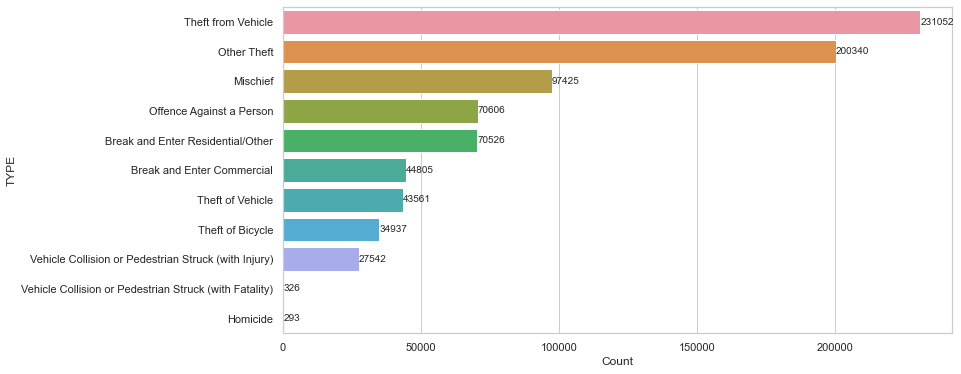

In [7]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x="Count", y="TYPE", data=grCrimes)
ax.bar_label(ax.containers[0])
plt.show()

## This graphic presents the total amount of crimes committed in Vancouver by neighborhood.

In [8]:
nbCrimes = crimes.groupby(['NEIGHBOURHOOD']).size().sort_values(ascending=False).reset_index(name="Count")

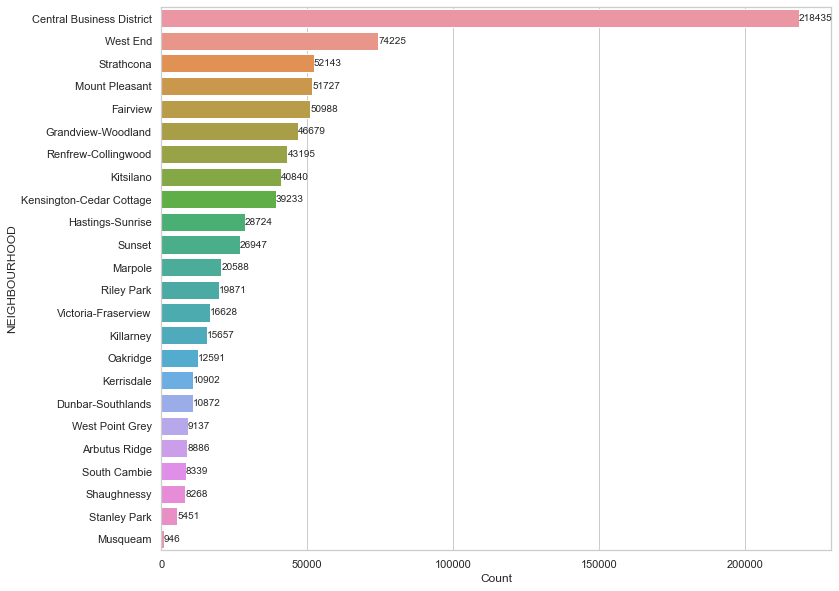

In [9]:
plt.figure(figsize=(12,10))
ax = sns.barplot(x="Count", y="NEIGHBOURHOOD", data=nbCrimes)
ax.bar_label(ax.containers[0])
plt.show()

## This graphic presents the total number of crimes committed in the Central Business District Vancouver neighborhood.

In [10]:
dtCrimes = crimes.loc[(crimes['NEIGHBOURHOOD']=='Central Business District')].groupby(['TYPE']).size().\
                                                                    sort_values(ascending=False).reset_index(name="Count")

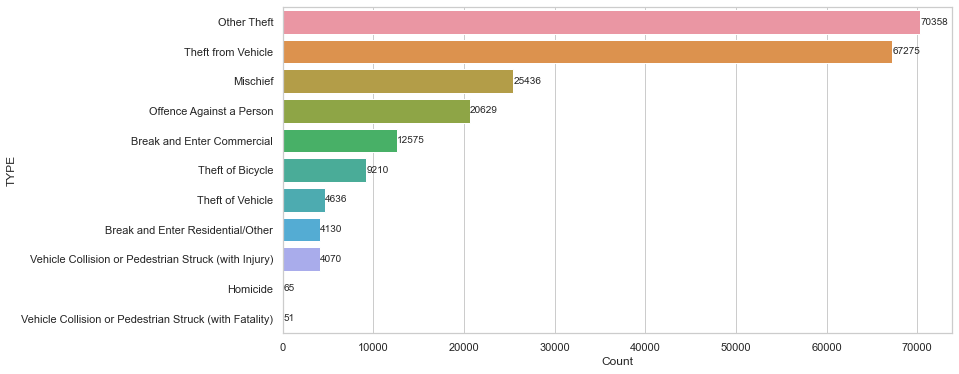

In [11]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x="Count", y="TYPE", data=dtCrimes)
ax.bar_label(ax.containers[0])
plt.show()

## This graphic presents the temporal behavior of crimes committed in Vancouver from 2003 to 2021 by category.

In [12]:
tscrimes = crimes.loc[(crimes['YEAR']< 2022)].groupby(['TYPE','YEAR']).size().reset_index(name="Count")

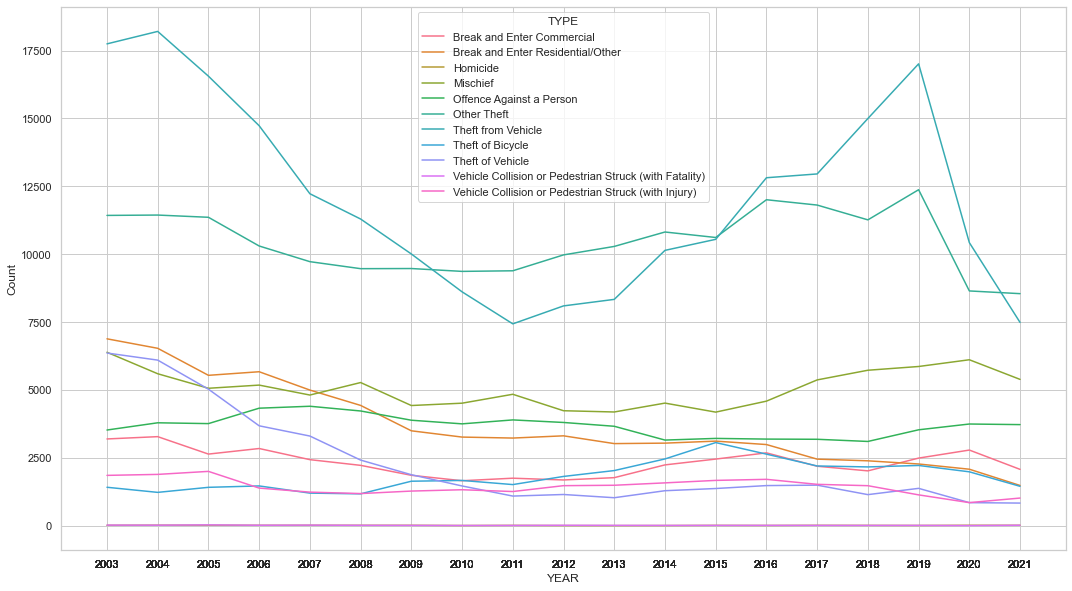

In [13]:
plt.figure(figsize=(18,10))
ax = sns.lineplot(data=tscrimes, x="YEAR", y="Count", hue="TYPE")
plt.xticks(tscrimes['YEAR'], rotation=0)
plt.show()

## This heatmap presents the behavior of Theft from Vehicle crimes in the Vancouver Central Business District neighborhood for each day of the weed and each hour of the day.

In [14]:
hourCrimes = crimes.loc[(crimes['TYPE'] == 'Theft from Vehicle') & (crimes['NEIGHBOURHOOD']=='Central Business District')]\
                                                                                            [['YEAR', 'MONTH', 'DAY', 'HOUR']]

hourCrimes['DATE'] = hourCrimes[['YEAR','MONTH','DAY']].\
                                  apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
hourCrimes['WEEKDAY'] =  hourCrimes['DATE'].apply(lambda x: pd.Timestamp(x).day_name())

In [15]:
heatCrimes = hourCrimes[['WEEKDAY','HOUR']].groupby(['WEEKDAY','HOUR']).size().reset_index(name="Count")
weekdays = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
heatCrimes['WEEKDAY'] = pd.Categorical(heatCrimes['WEEKDAY'],categories=weekdays)
heatCrimes = heatCrimes.sort_values('WEEKDAY')

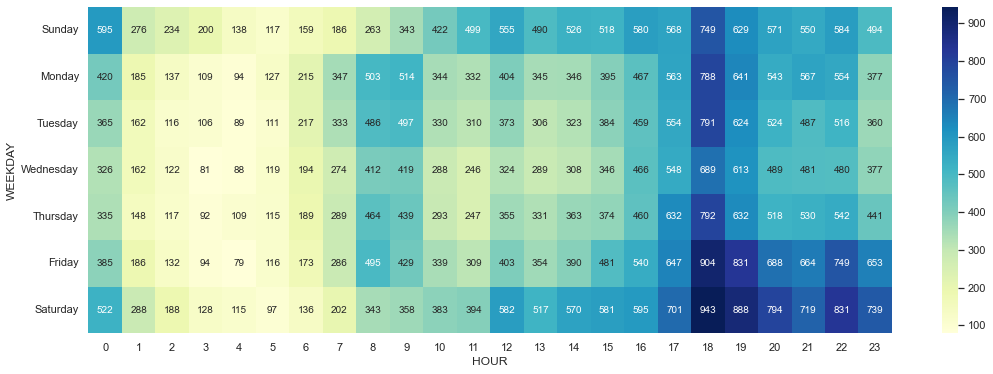

In [16]:
heatCrimesPivot = heatCrimes.pivot("WEEKDAY", "HOUR", "Count").sort_index(level=0, ascending=True)

plt.figure(figsize=(18,6))
ax = sns.heatmap(heatCrimesPivot, annot=True, fmt="d", cmap="YlGnBu")
plt.show()


## This map shows the theft of vehicles and bicycles during December 2021.

In [17]:
crimes2021Loc = crimes.loc[((crimes['TYPE'] == 'Theft of Vehicle') | (crimes['TYPE'] == 'Theft of Bicycle')) & \
                                                       (crimes['YEAR'] == 2021) & (crimes['MONTH'] == 12)][['TYPE', 'X', 'Y']]

crimes2021Loc[["Latitude", "Longitude"]] = crimes2021Loc.apply(lambda x: utm.to_latlon(x['X'], x['Y'], 10, 'U'),\
                                                                                        axis="columns", result_type="expand")

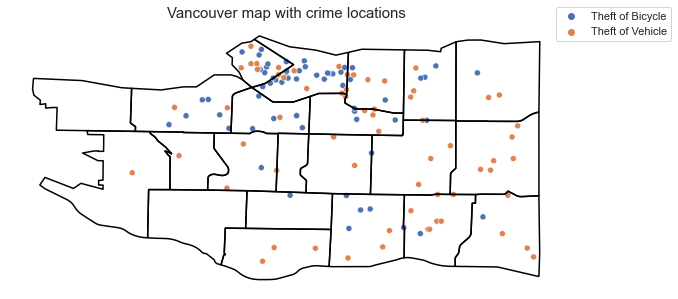

In [18]:
vanGeojson = gpd.read_file('local-area-boundary.geojson')

fig, ax = plt.subplots(figsize = (10,8))

vanGeojson.boundary.plot(ax = ax, edgecolor = 'black')

sns.scatterplot(crimes2021Loc['Longitude'], crimes2021Loc['Latitude'], marker = 'o', hue = crimes2021Loc['TYPE'])

ax.legend(loc='center right', bbox_to_anchor=(1.2, 1), ncol=1)

ax.axis('off')

plt.title('Vancouver map with crime locations', fontsize=15)
plt.show()